In [21]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from typing import Dict, Any, Type

In [22]:
torch.manual_seed(21)

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [24]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),   #это для ImageNet, предположим, что такие значения подойдут
    # torchvision.transforms.transforms.RandomAffine(
    #                           degrees=30, translate=(0.5, 0.5), scale=(0.25, 1),
    #                           shear=(-30, 30, -30, 30)),
    torchvision.transforms.RandomVerticalFlip()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [25]:
train_dataset = datasets.CIFAR10('./cifar10', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10('./cifar10', train=False, download=True, transform =transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
num_classes = len(train_dataset.classes)

In [27]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class: horse


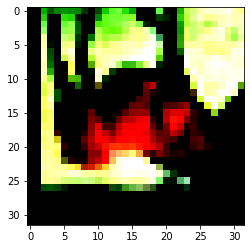

In [28]:
img, label = train_dataset[7]
plt.imshow(img.permute((1, 2, 0)))
print('class:', classes[label])

In [29]:
val_size = 5000
test_size = 5000

test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

In [30]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=256, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=256, 
                                          shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=256, 
                                          shuffle=False)

In [31]:
print('Number of classes:', num_classes)
print('Train dataset size:', len(train_dataset))
print('Val dataset size:', len(val_dataset))
print('Test dataset size:', len(test_dataset))

Number of classes: 10
Train dataset size: 50000
Val dataset size: 5000
Test dataset size: 5000


In [32]:
!nvidia-smi

Tue Jul  6 15:07:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |   1068MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, in_tensor):
        out = self.conv(in_tensor)
        out = self.relu(self.bn(out))
        return out

class VGG_like(nn.Module):
    def __init__(self, num_classes):
        super(VGG_like, self).__init__()
        self.num_classes = num_classes
        self.in_preproc = nn.Sequential(
            ConvBlock(3, 64),
            nn.MaxPool2d((2, 2))
        )
        self.layer = nn.Sequential(
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d((2, 2)),
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d((2, 2)),
            ConvBlock(128, 128),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, self.num_classes)
        )
        
    def forward(self, in_tensor):
        x = self.in_preproc(in_tensor)
        x = self.layer(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [34]:
model = VGG_like(num_classes=num_classes)

In [35]:
model.to(device)

VGG_like(
  (in_preproc): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): LeakyReLU(negative_slope=0.01)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): LeakyReLU(negative_slope=0.01)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): LeakyReLU(negative_slope=0.01)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, 

In [36]:
from tqdm import tqdm

In [37]:
def train_single_epoch(model: torch.nn.Module,
                                    optimizer: torch.optim.Optimizer, 
                                    loss_classifier: torch.nn.Module,
                                    data_loader: torch.utils.data.DataLoader,
                                    epoch: int):
    
    model.train()
    loss_value = []
    pbar = tqdm(data_loader)
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device=device, dtype=torch.int64)
        optimizer.zero_grad()
        y_pred = model(x)

        loss = loss_classifier(y_pred, y).float()
        loss.backward()
        loss_value.append(loss.item())
        optimizer.step()
        pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)
    pbar.close()      
    
    return loss_value

In [38]:
def validate_single_epoch(model: torch.nn.Module,
                                       loss_classifier: torch.nn.Module, 
                                       data_loader: torch.utils.data.DataLoader):
    
    val_results = {'loss': 0, 'accuracy': 0}
    
    model.eval()
    pbar = tqdm(data_loader)
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.long()
            y = y.to(device=device, dtype=torch.int64)
            y_pred = model(x)
            loss = loss_classifier(y_pred, y).float().item()
            accuracy = torch.sum(torch.argmax(y_pred, dim=1) == y).to(torch.float).item()
            val_results['loss'] += loss
            val_results['accuracy'] += accuracy
            pbar.update(1)
            #pbar.set_postfix({'loss': loss, 'accuracy': accuracy})
        val_results['loss'] /= len(data_loader.dataset)
        val_results['accuracy'] /= len(data_loader.dataset)

    pbar.close()
    return val_results

In [39]:
def train_model(model: torch.nn.Module, 
                train_loader: DataLoader,
                val_loader: DataLoader,
                loss_classifier: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.001,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                max_epochs = 10):

    optimizer = torch.optim.Adam([
                {'params': model.parameters(), 'lr': 1e-4},
            ], **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)

    best_val_loss = None
    best_epoch = None
    
    loss_history = []
    history = []
    for epoch in range(max_epochs):

        print(f'Epoch {epoch + 1}/{max_epochs}')
        train_epoch_loss_history = train_single_epoch(model, optimizer, loss_classifier, train_loader, epoch)
        loss_history = loss_history+train_epoch_loss_history
        history.append(train_epoch_loss_history)

        val_metrics = validate_single_epoch(model, loss_classifier, val_loader)

        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')

        torch.save(model.state_dict(), f"./model_on_epoch_{epoch}.pth")

    return loss_history

In [64]:
history +=train_model(model, 
            train_loader=train_loader, 
            val_loader=val_loader, 
            loss_classifier=torch.nn.CrossEntropyLoss(),
            lr_scheduler_params={'factor': 0.3, 'patience': 5},
            initial_lr=0.00001,
            max_epochs=10)

  1%|          | 1/196 [00:00<00:28,  6.94it/s, loss=0.697]

Epoch 1/10


  1%|          | 1/196 [00:00<00:25,  7.78it/s, loss=0.668]

Validation metrics: 
{'loss': 0.0031045831441879274, 'accuracy': 0.7258}
Best model yet, saving
Epoch 2/10


  1%|          | 1/196 [00:00<00:25,  7.73it/s, loss=0.672]

Validation metrics: 
{'loss': 0.0030705315232276917, 'accuracy': 0.73}
Best model yet, saving
Epoch 3/10


  1%|          | 1/196 [00:00<00:24,  7.90it/s, loss=0.66]

Validation metrics: 
{'loss': 0.0029695085883140564, 'accuracy': 0.7418}
Best model yet, saving
Epoch 4/10


  1%|          | 1/196 [00:00<00:28,  6.87it/s, loss=0.729]

Validation metrics: 
{'loss': 0.0028777610063552856, 'accuracy': 0.748}
Best model yet, saving
Epoch 5/10


  1%|          | 1/196 [00:00<00:24,  8.08it/s, loss=0.684]

Validation metrics: 
{'loss': 0.003015303146839142, 'accuracy': 0.7418}
Epoch 6/10


  1%|          | 1/196 [00:00<00:23,  8.42it/s, loss=0.653]

Validation metrics: 
{'loss': 0.0028595532417297364, 'accuracy': 0.7506}
Best model yet, saving
Epoch 7/10


  1%|          | 1/196 [00:00<00:24,  7.81it/s, loss=0.555]

Validation metrics: 
{'loss': 0.0029759382605552675, 'accuracy': 0.7394}
Epoch 8/10


  1%|          | 1/196 [00:00<00:24,  7.89it/s, loss=0.555]

Validation metrics: 
{'loss': 0.002867679512500763, 'accuracy': 0.745}
Epoch 9/10


  1%|          | 1/196 [00:00<00:24,  7.88it/s, loss=0.577]

Validation metrics: 
{'loss': 0.0028447030544281006, 'accuracy': 0.754}
Best model yet, saving
Epoch 10/10


100%|██████████| 20/20 [00:01<00:00, 18.31it/s]

Validation metrics: 
{'loss': 0.0029866106510162355, 'accuracy': 0.7434}


Text(0.5, 1.0, 'Loss')

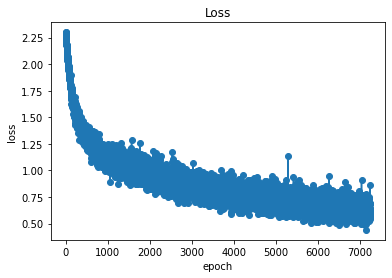

In [65]:
plt.plot(history, '-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

In [62]:
def test_model(model: torch.nn.Module, 
                            data_loader: torch.utils.data.DataLoader):
    acc = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.long()
            y = y.to(device=device, dtype=torch.int64)
            y_pred = model(x)
            accuracy = torch.sum(torch.argmax(y_pred, dim=1) == y).to(torch.float).item()
            acc += accuracy
        acc /= len(test_dataset)

    return acc

In [66]:
test_model(model, test_loader)

0.757